## CTKD with CIFAR100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torchvision.models as models
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
num_epochs = 240  # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
# weight_decay_input = 5e-4
weight_decay=1e-4
initial_temperature = 20.0

# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [4]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = models.resnet34(pretrained=True).to(device)
teacher_model.fc = nn.Linear(512, num_classes)

student_model = models.resnet18(pretrained=False).to(device)
student_model.fc = nn.Linear(512, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
# student_criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 regularization to prevent overfitting

teacher_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(teacher_optimizer, 'min', patience=3, factor=0.5)
student_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=3, factor=0.5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
# # CKD Optimizer and scheduler for the student model
# student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
# student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# # Optimizer and scheduler for the teacher model
# teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
# teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# criterion = nn.CrossEntropyLoss()

# # Assuming the device is a CUDA device if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:35<00:00,  2.33it/s]


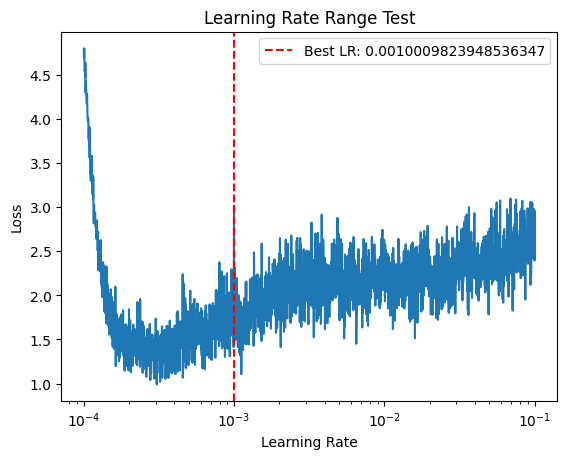

Best learning rate: 0.0010009823948536347
0.0010009823948536347


In [9]:
batch_size = 16  #to find the optimal learning rate
teacher_best_lr = train_teacher(teacher_model, trainloader, 
                                teacher_criterion, teacher_optimizer, teacher_scheduler, 
                                device, num_epochs=3)  
print(teacher_best_lr)

100%|████████████████████████████████████████████████████████████████████████| 782/782 [03:58<00:00,  3.27it/s]


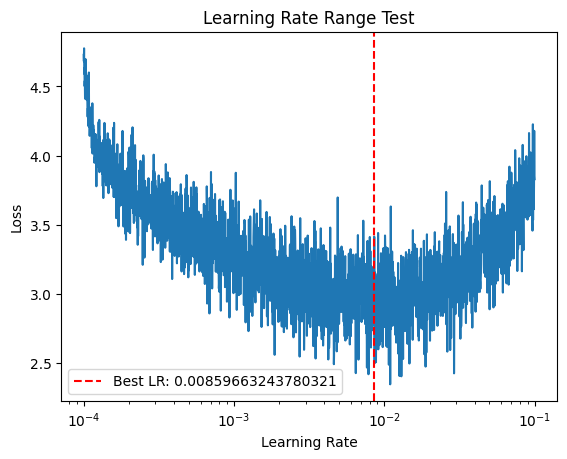

Best learning rate: 0.00859663243780321
0.00859663243780321


In [14]:
student_best_lr = train_teacher(student_model, trainloader, 
                                criterion, student_optimizer, student_scheduler, 
                                device, num_epochs=3)  
print(student_best_lr)

In [7]:
# teacher_learning_rate = teacher_best_lr
# student_learning_rate = student_best_lr

teacher_learning_rate = 0.0010009823948536347
student_learning_rate = 0.00859663243780321
# student_learning_rate = 0.001

In [8]:
# # Optimizer and scheduler for the student model
# student_optimizer = optim.SGD(student_model.parameters(), lr=student_learning_rate, momentum=momentum)
# student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# # Optimizer and scheduler for the teacher model
# teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_learning_rate, momentum=momentum)
# teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# criterion = nn.CrossEntropyLoss()

# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')

criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=teacher_learning_rate)
student_optimizer = optim.Adam(student_model.parameters(), lr=student_learning_rate, 
                               weight_decay=weight_decay)  # L2 regularization to prevent overfitting

teacher_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(teacher_optimizer, 'min', patience=3, factor=0.5)
student_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=3, factor=0.5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ctkd_cifar100_checkpoint.pth')
            torch.save(model, f'teacher_model_ctkd_cifar100_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step(epoch_loss)

    print("Finished Training Teacher")



# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ctkd_cifar_checkpoint.pth')
            torch.save(student, f'student_model_ctkd_cifar_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step(epoch_loss) 

    print("Finished Training Student")

In [10]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, teacher_criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)


 13%|█████████▏                                                              | 100/782 [00:43<04:50,  2.34it/s]

[1, 100] loss: 3.757


 26%|██████████████████▍                                                     | 200/782 [01:26<04:09,  2.34it/s]

[1, 200] loss: 2.879


 38%|███████████████████████████▌                                            | 300/782 [02:09<03:25,  2.34it/s]

[1, 300] loss: 2.485


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[1, 400] loss: 2.294


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[1, 500] loss: 2.106


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.31it/s]

[1, 600] loss: 1.987


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[1, 700] loss: 1.875


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[2, 100] loss: 1.560


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[2, 200] loss: 1.565


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[2, 300] loss: 1.539


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[2, 400] loss: 1.492


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[2, 500] loss: 1.418


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[2, 600] loss: 1.436


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[2, 700] loss: 1.393


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[3, 100] loss: 1.109


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[3, 200] loss: 1.071


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[3, 300] loss: 1.101


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[3, 400] loss: 1.113


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.35it/s]

[3, 500] loss: 1.128


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[3, 600] loss: 1.087


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[3, 700] loss: 1.110


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[4, 100] loss: 0.802


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[4, 200] loss: 0.790


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[4, 300] loss: 0.845


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[4, 400] loss: 0.838


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[4, 500] loss: 0.844


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[4, 600] loss: 0.839


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[4, 700] loss: 0.866


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[5, 100] loss: 0.588


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[5, 200] loss: 0.556


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[5, 300] loss: 0.594


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[5, 400] loss: 0.606


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[5, 500] loss: 0.641


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[5, 600] loss: 0.658


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[5, 700] loss: 0.650


 13%|█████████▏                                                              | 100/782 [00:43<04:52,  2.33it/s]

[6, 100] loss: 0.400


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[6, 200] loss: 0.367


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[6, 300] loss: 0.395


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[6, 400] loss: 0.427


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[6, 500] loss: 0.446


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[6, 600] loss: 0.455


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[6, 700] loss: 0.507


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[7, 100] loss: 0.273


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[7, 200] loss: 0.224


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[7, 300] loss: 0.271


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:45,  2.31it/s]

[7, 400] loss: 0.308


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[7, 500] loss: 0.334


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[7, 600] loss: 0.373


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[7, 700] loss: 0.365


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[8, 100] loss: 0.190


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[8, 200] loss: 0.178


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:28,  2.31it/s]

[8, 300] loss: 0.196


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[8, 400] loss: 0.233


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[8, 500] loss: 0.258


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[8, 600] loss: 0.264


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[8, 700] loss: 0.324


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[9, 100] loss: 0.185


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[9, 200] loss: 0.148


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[9, 300] loss: 0.145


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[9, 400] loss: 0.165


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[9, 500] loss: 0.191


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[9, 600] loss: 0.230


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[9, 700] loss: 0.242


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[10, 100] loss: 0.153


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[10, 200] loss: 0.120


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[10, 300] loss: 0.125


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[10, 400] loss: 0.147


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[10, 500] loss: 0.171


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[10, 600] loss: 0.214


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.32it/s]

[10, 700] loss: 0.194


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[11, 100] loss: 0.165


 26%|██████████████████▍                                                     | 200/782 [01:25<04:07,  2.35it/s]

[11, 200] loss: 0.129


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[11, 300] loss: 0.124


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:43,  2.33it/s]

[11, 400] loss: 0.126


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[11, 500] loss: 0.132


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[11, 600] loss: 0.174


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[11, 700] loss: 0.175


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[12, 100] loss: 0.152


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[12, 200] loss: 0.117


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[12, 300] loss: 0.124


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[12, 400] loss: 0.135


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[12, 500] loss: 0.139


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[12, 600] loss: 0.156


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[12, 700] loss: 0.126


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[13, 100] loss: 0.113


 26%|██████████████████▍                                                     | 200/782 [01:25<04:11,  2.32it/s]

[13, 200] loss: 0.101


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[13, 300] loss: 0.097


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[13, 400] loss: 0.095


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[13, 500] loss: 0.120


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[13, 600] loss: 0.129


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[13, 700] loss: 0.155


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[14, 100] loss: 0.098


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[14, 200] loss: 0.089


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[14, 300] loss: 0.093


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[14, 400] loss: 0.112


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[14, 500] loss: 0.130


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[14, 600] loss: 0.126


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[14, 700] loss: 0.155


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.32it/s]

[15, 100] loss: 0.095


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[15, 200] loss: 0.087


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[15, 300] loss: 0.092


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[15, 400] loss: 0.109


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[15, 500] loss: 0.107


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[15, 600] loss: 0.117


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[15, 700] loss: 0.147


 13%|█████████▏                                                              | 100/782 [00:42<04:49,  2.36it/s]

[16, 100] loss: 0.079


 26%|██████████████████▍                                                     | 200/782 [01:24<04:05,  2.37it/s]

[16, 200] loss: 0.075


 38%|███████████████████████████▌                                            | 300/782 [02:06<03:23,  2.37it/s]

[16, 300] loss: 0.070


 51%|████████████████████████████████████▊                                   | 400/782 [02:48<02:43,  2.34it/s]

[16, 400] loss: 0.083


 64%|██████████████████████████████████████████████                          | 500/782 [03:31<02:00,  2.35it/s]

[16, 500] loss: 0.083


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:14<01:18,  2.32it/s]

[16, 600] loss: 0.119


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:57<00:35,  2.34it/s]

[16, 700] loss: 0.100


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.34it/s]

[17, 100] loss: 0.092


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[17, 200] loss: 0.071


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[17, 300] loss: 0.073


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:42,  2.34it/s]

[17, 400] loss: 0.077


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[17, 500] loss: 0.064


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[17, 600] loss: 0.091


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[17, 700] loss: 0.106


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[18, 100] loss: 0.091


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[18, 200] loss: 0.079


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[18, 300] loss: 0.073


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[18, 400] loss: 0.094


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[18, 500] loss: 0.085


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[18, 600] loss: 0.115


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[18, 700] loss: 0.130


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[19, 100] loss: 0.068


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[19, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[19, 300] loss: 0.057


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:45,  2.31it/s]

[19, 400] loss: 0.059


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[19, 500] loss: 0.066


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[19, 600] loss: 0.071


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[19, 700] loss: 0.099


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[20, 100] loss: 0.068


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[20, 200] loss: 0.054


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[20, 300] loss: 0.090


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[20, 400] loss: 0.078


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[20, 500] loss: 0.080


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[20, 600] loss: 0.087


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[20, 700] loss: 0.082


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[21, 100] loss: 0.071


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[21, 200] loss: 0.050


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[21, 300] loss: 0.050


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[21, 400] loss: 0.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[21, 500] loss: 0.062


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[21, 600] loss: 0.090


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[21, 700] loss: 0.097


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[22, 100] loss: 0.088


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[22, 200] loss: 0.070


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[22, 300] loss: 0.079


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[22, 400] loss: 0.065


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[22, 500] loss: 0.070


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[22, 600] loss: 0.052


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[22, 700] loss: 0.061


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[23, 100] loss: 0.078


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[23, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[23, 300] loss: 0.072


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[23, 400] loss: 0.064


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[23, 500] loss: 0.062


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[23, 600] loss: 0.056


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[23, 700] loss: 0.078


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[24, 100] loss: 0.083


 26%|██████████████████▍                                                     | 200/782 [01:25<04:06,  2.36it/s]

[24, 200] loss: 0.040


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[24, 300] loss: 0.052


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[24, 400] loss: 0.068


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[24, 500] loss: 0.063


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[24, 600] loss: 0.053


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[24, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[25, 100] loss: 0.077


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[25, 200] loss: 0.054


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[25, 300] loss: 0.064


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[25, 400] loss: 0.064


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[25, 500] loss: 0.071


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[25, 600] loss: 0.066


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[25, 700] loss: 0.079


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[26, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[26, 200] loss: 0.038


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:28,  2.32it/s]

[26, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[26, 400] loss: 0.045


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[26, 500] loss: 0.056


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[26, 600] loss: 0.071


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[26, 700] loss: 0.070


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[27, 100] loss: 0.052


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[27, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[27, 300] loss: 0.059


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[27, 400] loss: 0.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[27, 500] loss: 0.064


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[27, 600] loss: 0.057


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[27, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[28, 100] loss: 0.054


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.33it/s]

[28, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[28, 300] loss: 0.053


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[28, 400] loss: 0.057


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[28, 500] loss: 0.056


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[28, 600] loss: 0.043


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[28, 700] loss: 0.063


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[29, 100] loss: 0.080


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[29, 200] loss: 0.063


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[29, 300] loss: 0.047


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[29, 400] loss: 0.047


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.32it/s]

[29, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[29, 600] loss: 0.054


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[29, 700] loss: 0.054


 13%|█████████▏                                                              | 100/782 [00:42<04:54,  2.32it/s]

[30, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[30, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[30, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[30, 400] loss: 0.046


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[30, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[30, 600] loss: 0.055


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[30, 700] loss: 0.060


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[31, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[31, 200] loss: 0.042


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[31, 300] loss: 0.053


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[31, 400] loss: 0.038


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[31, 500] loss: 0.047


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[31, 600] loss: 0.059


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[31, 700] loss: 0.064


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[32, 100] loss: 0.055


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[32, 200] loss: 0.047


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[32, 300] loss: 0.039


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[32, 400] loss: 0.039


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[32, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[32, 600] loss: 0.070


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[32, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[33, 100] loss: 0.056


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[33, 200] loss: 0.038


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[33, 300] loss: 0.036


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[33, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.34it/s]

[33, 500] loss: 0.047


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[33, 600] loss: 0.049


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[33, 700] loss: 0.046


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[34, 100] loss: 0.054


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[34, 200] loss: 0.047


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[34, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[34, 400] loss: 0.052


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[34, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[34, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[34, 700] loss: 0.042


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.34it/s]

[35, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[35, 200] loss: 0.035


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[35, 300] loss: 0.048


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[35, 400] loss: 0.037


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[35, 500] loss: 0.041


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[35, 600] loss: 0.045


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[35, 700] loss: 0.040


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.35it/s]

[36, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[36, 200] loss: 0.033


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[36, 300] loss: 0.043


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:43,  2.34it/s]

[36, 400] loss: 0.048


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[36, 500] loss: 0.060


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[36, 600] loss: 0.056


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[36, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[37, 100] loss: 0.037


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[37, 200] loss: 0.045


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[37, 300] loss: 0.043


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[37, 400] loss: 0.038


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[37, 500] loss: 0.027


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[37, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[37, 700] loss: 0.034


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[38, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[38, 200] loss: 0.025


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[38, 300] loss: 0.040


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[38, 400] loss: 0.054


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[38, 500] loss: 0.049


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[38, 600] loss: 0.051


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[38, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[39, 100] loss: 0.040


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[39, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[39, 300] loss: 0.029


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[39, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[39, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[39, 600] loss: 0.061


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[39, 700] loss: 0.051


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[40, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.33it/s]

[40, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[40, 300] loss: 0.032


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[40, 400] loss: 0.043


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[40, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[40, 600] loss: 0.039


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[40, 700] loss: 0.064


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[41, 100] loss: 0.040


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[41, 200] loss: 0.029


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[41, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[41, 400] loss: 0.028


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[41, 500] loss: 0.040


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[41, 600] loss: 0.050


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[41, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[42, 100] loss: 0.022


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[42, 200] loss: 0.013


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[42, 300] loss: 0.009


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[42, 400] loss: 0.010


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[42, 500] loss: 0.006


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[42, 600] loss: 0.005


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[42, 700] loss: 0.008


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[43, 100] loss: 0.002


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[43, 200] loss: 0.003


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[43, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[43, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[43, 500] loss: 0.003


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[43, 600] loss: 0.003


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[43, 700] loss: 0.002


 13%|█████████▏                                                              | 100/782 [00:43<04:52,  2.33it/s]

[44, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[44, 200] loss: 0.003


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[44, 300] loss: 0.001


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[44, 400] loss: 0.001


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[44, 500] loss: 0.001


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[44, 600] loss: 0.002


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[44, 700] loss: 0.002


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[45, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:11,  2.32it/s]

[45, 200] loss: 0.002


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[45, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[45, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[45, 500] loss: 0.006


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.32it/s]

[45, 600] loss: 0.006


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.32it/s]

[45, 700] loss: 0.006


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[46, 100] loss: 0.009


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[46, 200] loss: 0.010


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[46, 300] loss: 0.012


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[46, 400] loss: 0.017


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[46, 500] loss: 0.014


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[46, 600] loss: 0.019


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[46, 700] loss: 0.017


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[47, 100] loss: 0.012


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[47, 200] loss: 0.006


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[47, 300] loss: 0.007


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[47, 400] loss: 0.005


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[47, 500] loss: 0.005


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[47, 600] loss: 0.005


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[47, 700] loss: 0.004


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[48, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[48, 200] loss: 0.002


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[48, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[48, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[48, 500] loss: 0.001


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[48, 600] loss: 0.004


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[48, 700] loss: 0.011


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[49, 100] loss: 0.010


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[49, 200] loss: 0.005


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[49, 300] loss: 0.004


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[49, 400] loss: 0.004


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[49, 500] loss: 0.003


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[49, 600] loss: 0.002


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:34,  2.34it/s]

[49, 700] loss: 0.003


100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:34<00:00,  2.34it/s]

Early stopping
Finished Training Teacher


In [11]:
# Save the teacher model 
torch.save(teacher_model.state_dict(), 'teacher_model_weights_ctkd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_ctkd_cifar100.pth')
print('teacher weights and architecture saved and exported')

teacher weights and architecture saved and exported


In [12]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # # Load the student model architecture and weights
# # student_model = torch.load('student_model_ctkd_cifar100.pth')
# # student_model.load_state_dict(torch.load('student_model_weights_ctkd_cifar100.pth'))
# # student_model = student_model.to(device)

# # Load the student model architecture and weights
# teacher_model = torch.load('teacher_model_ctkd_cifar100.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ctkd_cifar100.pth'))
# teacher_model = teacher_model.to(device)

In [ ]:
# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, 
                                student_optimizer, student_scheduler, device, alpha, temperature, 
                                num_epochs=num_epochs)


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[1, 100] loss: 3.931


 26%|██████████████████▍                                                     | 200/782 [01:19<03:52,  2.50it/s]

[1, 200] loss: 3.763


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.49it/s]

[1, 300] loss: 3.655


 51%|████████████████████████████████████▊                                   | 400/782 [02:39<02:32,  2.50it/s]

[1, 400] loss: 3.563


 64%|██████████████████████████████████████████████                          | 500/782 [03:19<01:52,  2.51it/s]

[1, 500] loss: 3.494


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:59<01:12,  2.51it/s]

[1, 600] loss: 3.435


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:39<00:32,  2.51it/s]

[1, 700] loss: 3.406


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[2, 100] loss: 3.283


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[2, 200] loss: 3.219


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:11,  2.52it/s]

[2, 300] loss: 3.182


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[2, 400] loss: 3.114


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[2, 500] loss: 3.059


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.53it/s]

[2, 600] loss: 3.038


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[2, 700] loss: 2.975


 13%|█████████▏                                                              | 100/782 [00:39<04:33,  2.50it/s]

[3, 100] loss: 2.902


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[3, 200] loss: 2.851


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[3, 300] loss: 2.815


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[3, 400] loss: 2.774


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[3, 500] loss: 2.745


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[3, 600] loss: 2.762


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[3, 700] loss: 2.660


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[4, 100] loss: 2.654


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[4, 200] loss: 2.581


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[4, 300] loss: 2.577


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[4, 400] loss: 2.593


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[4, 500] loss: 2.576


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[4, 600] loss: 2.556


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[4, 700] loss: 2.537


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[5, 100] loss: 2.435


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[5, 200] loss: 2.454


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[5, 300] loss: 2.456


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[5, 400] loss: 2.455


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[5, 500] loss: 2.411


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[5, 600] loss: 2.435


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[5, 700] loss: 2.437


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[6, 100] loss: 2.339


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[6, 200] loss: 2.335


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[6, 300] loss: 2.360


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[6, 400] loss: 2.344


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[6, 500] loss: 2.333


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[6, 600] loss: 2.356


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[6, 700] loss: 2.356


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[7, 100] loss: 2.282


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[7, 200] loss: 2.307


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[7, 300] loss: 2.301


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[7, 400] loss: 2.309


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[7, 500] loss: 2.280


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[7, 600] loss: 2.286


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[7, 700] loss: 2.284


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[8, 100] loss: 2.237


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[8, 200] loss: 2.250


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[8, 300] loss: 2.236


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[8, 400] loss: 2.250


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[8, 500] loss: 2.230


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[8, 600] loss: 2.203


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.51it/s]

[8, 700] loss: 2.241


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[9, 100] loss: 2.157


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[9, 200] loss: 2.169


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[9, 300] loss: 2.208


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[9, 400] loss: 2.204


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[9, 500] loss: 2.190


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[9, 600] loss: 2.185


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[9, 700] loss: 2.214


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[10, 100] loss: 2.128


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[10, 200] loss: 2.146


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[10, 300] loss: 2.129


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[10, 400] loss: 2.177


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[10, 500] loss: 2.141


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[10, 600] loss: 2.180


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[10, 700] loss: 2.132


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.54it/s]

[11, 100] loss: 2.114


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[11, 200] loss: 2.103


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[11, 300] loss: 2.118


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[11, 400] loss: 2.094


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[11, 500] loss: 2.124


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[11, 600] loss: 2.139


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[11, 700] loss: 2.119


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[12, 100] loss: 2.075


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[12, 200] loss: 2.081


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[12, 300] loss: 2.108


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[12, 400] loss: 2.062


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[12, 500] loss: 2.095


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[12, 600] loss: 2.117


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[12, 700] loss: 2.105


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[13, 100] loss: 2.055


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[13, 200] loss: 2.056


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[13, 300] loss: 2.046


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[13, 400] loss: 2.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[13, 500] loss: 2.086


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[13, 600] loss: 2.063


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[13, 700] loss: 2.051


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[14, 100] loss: 1.992


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[14, 200] loss: 2.048


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[14, 300] loss: 2.050


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[14, 400] loss: 2.052


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[14, 500] loss: 2.021


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[14, 600] loss: 2.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[14, 700] loss: 2.028


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[15, 100] loss: 2.017


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[15, 200] loss: 1.979


 38%|███████████████████████████▌                                            | 300/782 [01:57<03:10,  2.53it/s]

[15, 300] loss: 2.013


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:30,  2.53it/s]

[15, 400] loss: 2.030


 64%|██████████████████████████████████████████████                          | 500/782 [03:16<01:51,  2.53it/s]

[15, 500] loss: 2.022


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:11,  2.53it/s]

[15, 600] loss: 2.011


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:35<00:32,  2.53it/s]

[15, 700] loss: 2.011


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[16, 100] loss: 1.985


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[16, 200] loss: 1.991


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[16, 300] loss: 1.975


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[16, 400] loss: 1.995


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[16, 500] loss: 2.010


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[16, 600] loss: 1.993


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[16, 700] loss: 2.005


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[17, 100] loss: 1.966


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[17, 200] loss: 1.971


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[17, 300] loss: 1.970


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[17, 400] loss: 1.960


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[17, 500] loss: 1.968


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[17, 600] loss: 1.999


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[17, 700] loss: 1.980


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[18, 100] loss: 1.928


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[18, 200] loss: 1.976


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[18, 300] loss: 1.965


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[18, 400] loss: 1.968


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[18, 500] loss: 1.985


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[18, 600] loss: 1.932


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[18, 700] loss: 1.978


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[19, 100] loss: 1.911


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[19, 200] loss: 1.935


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[19, 300] loss: 1.948


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[19, 400] loss: 1.935


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[19, 500] loss: 1.939


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[19, 600] loss: 1.974


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[19, 700] loss: 1.968


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[20, 100] loss: 1.880


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[20, 200] loss: 1.926


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[20, 300] loss: 1.935


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[20, 400] loss: 1.947


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[20, 500] loss: 1.960


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[20, 600] loss: 1.957


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[20, 700] loss: 1.940


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[21, 100] loss: 1.890


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[21, 200] loss: 1.929


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[21, 300] loss: 1.910


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[21, 400] loss: 1.931


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[21, 500] loss: 1.941


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[21, 600] loss: 1.937


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[21, 700] loss: 1.958


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[22, 100] loss: 1.906


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[22, 200] loss: 1.899


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[22, 300] loss: 1.918


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[22, 400] loss: 1.899


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[22, 500] loss: 1.930


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[22, 600] loss: 1.890


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[22, 700] loss: 1.949


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[23, 100] loss: 1.879


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[23, 200] loss: 1.875


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[23, 300] loss: 1.910


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[23, 400] loss: 1.940


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[23, 500] loss: 1.906


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[23, 600] loss: 1.896


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[23, 700] loss: 1.931


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[24, 100] loss: 1.874


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[24, 200] loss: 1.858


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[24, 300] loss: 1.904


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[24, 400] loss: 1.914


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[24, 500] loss: 1.923


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[24, 600] loss: 1.912


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[24, 700] loss: 1.879


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[25, 100] loss: 1.854


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[25, 200] loss: 1.875


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[25, 300] loss: 1.907


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[25, 400] loss: 1.877


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[25, 500] loss: 1.893


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[25, 600] loss: 1.896


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[25, 700] loss: 1.911


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[26, 100] loss: 1.856


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[26, 200] loss: 1.881


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[26, 300] loss: 1.878


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[26, 400] loss: 1.867


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[26, 500] loss: 1.882


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[26, 600] loss: 1.893


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[26, 700] loss: 1.879


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[27, 100] loss: 1.833


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[27, 200] loss: 1.859


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[27, 300] loss: 1.881


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[27, 400] loss: 1.886


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[27, 500] loss: 1.868


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[27, 600] loss: 1.891


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[27, 700] loss: 1.860


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[28, 100] loss: 1.842


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[28, 200] loss: 1.817


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[28, 300] loss: 1.870


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[28, 400] loss: 1.874


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[28, 500] loss: 1.868


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[28, 600] loss: 1.853


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[28, 700] loss: 1.871


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[29, 100] loss: 1.863


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[29, 200] loss: 1.848


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[29, 300] loss: 1.858


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[29, 400] loss: 1.854


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[29, 500] loss: 1.852


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[29, 600] loss: 1.884


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[29, 700] loss: 1.851


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[30, 100] loss: 1.808


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[30, 200] loss: 1.857


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[30, 300] loss: 1.858


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[30, 400] loss: 1.849


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[30, 500] loss: 1.831


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[30, 600] loss: 1.869


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[30, 700] loss: 1.866


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[31, 100] loss: 1.781


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[31, 200] loss: 1.831


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.50it/s]

[31, 300] loss: 1.879


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[31, 400] loss: 1.852


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[31, 500] loss: 1.871


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[31, 600] loss: 1.837


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[31, 700] loss: 1.830


 13%|█████████▏                                                              | 100/782 [00:39<04:27,  2.55it/s]

[32, 100] loss: 1.782


 26%|██████████████████▍                                                     | 200/782 [01:18<03:48,  2.55it/s]

[32, 200] loss: 1.826


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[32, 300] loss: 1.836


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:31,  2.52it/s]

[32, 400] loss: 1.842


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[32, 500] loss: 1.848


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:12,  2.52it/s]

[32, 600] loss: 1.865


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[32, 700] loss: 1.861


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[33, 100] loss: 1.808


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[33, 200] loss: 1.794


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[33, 300] loss: 1.842


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[33, 400] loss: 1.830


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[33, 500] loss: 1.825


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:13,  2.47it/s]

[33, 600] loss: 1.846


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[33, 700] loss: 1.860


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[34, 100] loss: 1.793


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[34, 200] loss: 1.830


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[34, 300] loss: 1.824


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[34, 400] loss: 1.851


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[34, 500] loss: 1.847


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[34, 600] loss: 1.820


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[34, 700] loss: 1.821


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[35, 100] loss: 1.765


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[35, 200] loss: 1.784


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[35, 300] loss: 1.830


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[35, 400] loss: 1.804


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[35, 500] loss: 1.858


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[35, 600] loss: 1.845


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[35, 700] loss: 1.820


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[36, 100] loss: 1.785


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[36, 200] loss: 1.810


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[36, 300] loss: 1.824


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[36, 400] loss: 1.846


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[36, 500] loss: 1.834


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[36, 600] loss: 1.811


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[36, 700] loss: 1.818


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[37, 100] loss: 1.795


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[37, 200] loss: 1.806


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[37, 300] loss: 1.800


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[37, 400] loss: 1.823


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[37, 500] loss: 1.830


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[37, 600] loss: 1.818


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[37, 700] loss: 1.845


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[38, 100] loss: 1.789


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[38, 200] loss: 1.814


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[38, 300] loss: 1.822


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[38, 400] loss: 1.779


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[38, 500] loss: 1.817


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[38, 600] loss: 1.797


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[38, 700] loss: 1.833


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[39, 100] loss: 1.759


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[39, 200] loss: 1.810


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[39, 300] loss: 1.801


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[39, 400] loss: 1.802


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[39, 500] loss: 1.809


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[39, 600] loss: 1.808


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[39, 700] loss: 1.792


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[40, 100] loss: 1.777


 26%|██████████████████▍                                                     | 200/782 [01:19<03:52,  2.50it/s]

[40, 200] loss: 1.776


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[40, 300] loss: 1.808


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[40, 400] loss: 1.777


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[40, 500] loss: 1.810


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:13,  2.47it/s]

[40, 600] loss: 1.818


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[40, 700] loss: 1.822


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[41, 100] loss: 1.766


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[41, 200] loss: 1.814


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:10,  2.53it/s]

[41, 300] loss: 1.773


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[41, 400] loss: 1.785


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[41, 500] loss: 1.797


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[41, 600] loss: 1.827


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[41, 700] loss: 1.816


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[42, 100] loss: 1.753


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[42, 200] loss: 1.773


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[42, 300] loss: 1.786


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[42, 400] loss: 1.801


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[42, 500] loss: 1.827


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[42, 600] loss: 1.814


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[42, 700] loss: 1.795


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[43, 100] loss: 1.752


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[43, 200] loss: 1.822


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[43, 300] loss: 1.773


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[43, 400] loss: 1.778


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.52it/s]

[43, 500] loss: 1.808


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[43, 600] loss: 1.804


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[43, 700] loss: 1.782


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[44, 100] loss: 1.755


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[44, 200] loss: 1.771


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[44, 300] loss: 1.780


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[44, 400] loss: 1.782


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[44, 500] loss: 1.792


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[44, 600] loss: 1.802


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[44, 700] loss: 1.824


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[45, 100] loss: 1.766


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[45, 200] loss: 1.771


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[45, 300] loss: 1.792


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[45, 400] loss: 1.747


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[45, 500] loss: 1.808


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[45, 600] loss: 1.794


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[45, 700] loss: 1.791


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[46, 100] loss: 1.736


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[46, 200] loss: 1.746


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[46, 300] loss: 1.783


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[46, 400] loss: 1.818


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[46, 500] loss: 1.758


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[46, 600] loss: 1.783


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[46, 700] loss: 1.791


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[47, 100] loss: 1.699


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[47, 200] loss: 1.760


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:11,  2.52it/s]

[47, 300] loss: 1.792


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[47, 400] loss: 1.771


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[47, 500] loss: 1.804


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[47, 600] loss: 1.759


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[47, 700] loss: 1.783


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[48, 100] loss: 1.729


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[48, 200] loss: 1.737


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[48, 300] loss: 1.751


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[48, 400] loss: 1.760


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[48, 500] loss: 1.818


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[48, 600] loss: 1.777


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[48, 700] loss: 1.792


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[49, 100] loss: 1.757


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[49, 200] loss: 1.714


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[49, 300] loss: 1.760


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[49, 400] loss: 1.761


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[49, 500] loss: 1.792


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[49, 600] loss: 1.773


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[49, 700] loss: 1.799


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[50, 100] loss: 1.715


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[50, 200] loss: 1.740


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[50, 300] loss: 1.769


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[50, 400] loss: 1.777


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[50, 500] loss: 1.762


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[50, 600] loss: 1.797


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[50, 700] loss: 1.793


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[51, 100] loss: 1.735


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[51, 200] loss: 1.718


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[51, 300] loss: 1.749


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[51, 400] loss: 1.761


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[51, 500] loss: 1.782


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[51, 600] loss: 1.783


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[51, 700] loss: 1.797


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[52, 100] loss: 1.732


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[52, 200] loss: 1.738


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[52, 300] loss: 1.746


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.51it/s]

[52, 400] loss: 1.764


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[52, 500] loss: 1.750


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[52, 600] loss: 1.761


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[52, 700] loss: 1.818


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[53, 100] loss: 1.722


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[53, 200] loss: 1.752


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[53, 300] loss: 1.761


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[53, 400] loss: 1.752


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[53, 500] loss: 1.787


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[53, 600] loss: 1.759


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[53, 700] loss: 1.801


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[54, 100] loss: 1.698


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[54, 200] loss: 1.726


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[54, 300] loss: 1.726


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[54, 400] loss: 1.772


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[54, 500] loss: 1.786


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[54, 600] loss: 1.789


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[54, 700] loss: 1.797


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[55, 100] loss: 1.735


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[55, 200] loss: 1.720


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:11,  2.51it/s]

[55, 300] loss: 1.751


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[55, 400] loss: 1.746


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[55, 500] loss: 1.755


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[55, 600] loss: 1.784


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[55, 700] loss: 1.771


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[56, 100] loss: 1.693


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[56, 200] loss: 1.739


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.50it/s]

[56, 300] loss: 1.741


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[56, 400] loss: 1.747


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[56, 500] loss: 1.775


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:11,  2.53it/s]

[56, 600] loss: 1.800


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[56, 700] loss: 1.793


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[57, 100] loss: 1.733


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[57, 200] loss: 1.704


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[57, 300] loss: 1.741


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[57, 400] loss: 1.753


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[57, 500] loss: 1.776


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[57, 600] loss: 1.776


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[57, 700] loss: 1.763


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[58, 100] loss: 1.715


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[58, 200] loss: 1.704


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[58, 300] loss: 1.739


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[58, 400] loss: 1.760


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[58, 500] loss: 1.759


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[58, 600] loss: 1.754


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.50it/s]

[58, 700] loss: 1.744


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[59, 100] loss: 1.699


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[59, 200] loss: 1.748


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[59, 300] loss: 1.751


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[59, 400] loss: 1.741


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.50it/s]

[59, 500] loss: 1.762


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[59, 600] loss: 1.774


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[59, 700] loss: 1.776


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[60, 100] loss: 1.701


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[60, 200] loss: 1.717


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[60, 300] loss: 1.719


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[60, 400] loss: 1.754


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[60, 500] loss: 1.756


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[60, 600] loss: 1.782


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[60, 700] loss: 1.777


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[61, 100] loss: 1.712


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[61, 200] loss: 1.719


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[61, 300] loss: 1.726


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[61, 400] loss: 1.740


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[61, 500] loss: 1.771


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[61, 600] loss: 1.778


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[61, 700] loss: 1.775


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[62, 100] loss: 1.695


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[62, 200] loss: 1.734


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:19,  2.42it/s]

[62, 300] loss: 1.729


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:31,  2.53it/s]

[62, 400] loss: 1.744


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:51,  2.52it/s]

[62, 500] loss: 1.768


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.51it/s]

[62, 600] loss: 1.754


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:39<00:32,  2.52it/s]

[62, 700] loss: 1.758


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[63, 100] loss: 1.696


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[63, 200] loss: 1.697


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[63, 300] loss: 1.755


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[63, 400] loss: 1.743


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[63, 500] loss: 1.778


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[63, 600] loss: 1.747


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[63, 700] loss: 1.764


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[64, 100] loss: 1.694


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[64, 200] loss: 1.712


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[64, 300] loss: 1.746


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[64, 400] loss: 1.755


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[64, 500] loss: 1.773


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[64, 600] loss: 1.724


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[64, 700] loss: 1.766


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[65, 100] loss: 1.704


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[65, 200] loss: 1.717


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[65, 300] loss: 1.734


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[65, 400] loss: 1.727


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[65, 500] loss: 1.757


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[65, 600] loss: 1.730


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[65, 700] loss: 1.799


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[66, 100] loss: 1.691


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[66, 200] loss: 1.712


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[66, 300] loss: 1.754


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[66, 400] loss: 1.751


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.52it/s]

[66, 500] loss: 1.764


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[66, 600] loss: 1.720


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[66, 700] loss: 1.757


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[67, 100] loss: 1.699


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[67, 200] loss: 1.715


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[67, 300] loss: 1.743


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[67, 400] loss: 1.730


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[67, 500] loss: 1.731


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[67, 600] loss: 1.773


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[67, 700] loss: 1.747


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[68, 100] loss: 1.711


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[68, 200] loss: 1.735


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[68, 300] loss: 1.735


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[68, 400] loss: 1.722


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[68, 500] loss: 1.738


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[68, 600] loss: 1.763


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[68, 700] loss: 1.756


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[69, 100] loss: 1.713


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[69, 200] loss: 1.688


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[69, 300] loss: 1.708


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[69, 400] loss: 1.729


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[69, 500] loss: 1.713


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[69, 600] loss: 1.755


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[69, 700] loss: 1.766


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[70, 100] loss: 1.661


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[70, 200] loss: 1.708


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[70, 300] loss: 1.714


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[70, 400] loss: 1.751


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[70, 500] loss: 1.748


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[70, 600] loss: 1.744


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[70, 700] loss: 1.748


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[71, 100] loss: 1.695


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[71, 200] loss: 1.704


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[71, 300] loss: 1.727


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[71, 400] loss: 1.730


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[71, 500] loss: 1.766


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[71, 600] loss: 1.756


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[71, 700] loss: 1.750


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[72, 100] loss: 1.684


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[72, 200] loss: 1.721


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[72, 300] loss: 1.733


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[72, 400] loss: 1.732


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:53,  2.49it/s]

[72, 500] loss: 1.751


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[72, 600] loss: 1.730


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[72, 700] loss: 1.764


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[73, 100] loss: 1.689


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[73, 200] loss: 1.710


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[73, 300] loss: 1.701


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.50it/s]

[73, 400] loss: 1.746


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[73, 500] loss: 1.746


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[73, 600] loss: 1.735


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[73, 700] loss: 1.775


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[74, 100] loss: 1.664


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[74, 200] loss: 1.707


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.51it/s]

[74, 300] loss: 1.719


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[74, 400] loss: 1.759


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[74, 500] loss: 1.741


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[74, 600] loss: 1.742


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[74, 700] loss: 1.743


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[75, 100] loss: 1.574


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[75, 200] loss: 1.557


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[75, 300] loss: 1.532


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[75, 400] loss: 1.565


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[75, 500] loss: 1.567


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[75, 600] loss: 1.540


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[75, 700] loss: 1.574


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[76, 100] loss: 1.517


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[76, 200] loss: 1.508


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[76, 300] loss: 1.570


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[76, 400] loss: 1.536


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[76, 500] loss: 1.559


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[76, 600] loss: 1.537


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[76, 700] loss: 1.579


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[77, 100] loss: 1.513


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[77, 200] loss: 1.527


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[77, 300] loss: 1.569


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[77, 400] loss: 1.557


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[77, 500] loss: 1.528


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[77, 600] loss: 1.522


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[77, 700] loss: 1.558


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[78, 100] loss: 1.471


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[78, 200] loss: 1.515


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[78, 300] loss: 1.539


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[78, 400] loss: 1.565


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[78, 500] loss: 1.524


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.50it/s]

[78, 600] loss: 1.578


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[78, 700] loss: 1.533


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[79, 100] loss: 1.441


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[79, 200] loss: 1.501


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[79, 300] loss: 1.500


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[79, 400] loss: 1.516


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[79, 500] loss: 1.542


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[79, 600] loss: 1.544


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[79, 700] loss: 1.545


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[80, 100] loss: 1.473


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[80, 200] loss: 1.495


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[80, 300] loss: 1.523


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[80, 400] loss: 1.528


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[80, 500] loss: 1.555


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.50it/s]

[80, 600] loss: 1.534


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[80, 700] loss: 1.546


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[81, 100] loss: 1.459


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[81, 200] loss: 1.504


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:10,  2.52it/s]

[81, 300] loss: 1.552


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[81, 400] loss: 1.543


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[81, 500] loss: 1.519


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[81, 600] loss: 1.533


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[81, 700] loss: 1.502


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[82, 100] loss: 1.478


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[82, 200] loss: 1.513


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:11,  2.52it/s]

[82, 300] loss: 1.520


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[82, 400] loss: 1.523


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[82, 500] loss: 1.520


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.53it/s]

[82, 600] loss: 1.499


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[82, 700] loss: 1.538


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[83, 100] loss: 1.466


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[83, 200] loss: 1.459


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[83, 300] loss: 1.508


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[83, 400] loss: 1.511


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.52it/s]

[83, 500] loss: 1.524


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.50it/s]

[83, 600] loss: 1.553


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[83, 700] loss: 1.522


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[84, 100] loss: 1.478


 26%|██████████████████▍                                                     | 200/782 [01:19<03:52,  2.50it/s]

[84, 200] loss: 1.468


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[84, 300] loss: 1.492


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[84, 400] loss: 1.524


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[84, 500] loss: 1.530


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[84, 600] loss: 1.521


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[84, 700] loss: 1.511


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[85, 100] loss: 1.468


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[85, 200] loss: 1.476


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.51it/s]

[85, 300] loss: 1.478


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.51it/s]

[85, 400] loss: 1.509


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[85, 500] loss: 1.512


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[85, 600] loss: 1.522


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[85, 700] loss: 1.497


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[86, 100] loss: 1.431


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[86, 200] loss: 1.474


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:11,  2.52it/s]

[86, 300] loss: 1.469


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[86, 400] loss: 1.494


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[86, 500] loss: 1.518


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[86, 600] loss: 1.506


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[86, 700] loss: 1.545


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[87, 100] loss: 1.452


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[87, 200] loss: 1.473


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[87, 300] loss: 1.493


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[87, 400] loss: 1.507


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[87, 500] loss: 1.518


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[87, 600] loss: 1.516


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[87, 700] loss: 1.510


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[88, 100] loss: 1.482


 26%|██████████████████▍                                                     | 200/782 [01:19<03:57,  2.45it/s]

[88, 200] loss: 1.465


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:10,  2.53it/s]

[88, 300] loss: 1.461


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[88, 400] loss: 1.468


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[88, 500] loss: 1.482


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.51it/s]

[88, 600] loss: 1.512


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:38<00:32,  2.52it/s]

[88, 700] loss: 1.540


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[89, 100] loss: 1.453


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[89, 200] loss: 1.474


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[89, 300] loss: 1.474


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[89, 400] loss: 1.487


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[89, 500] loss: 1.505


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[89, 600] loss: 1.512


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[89, 700] loss: 1.556


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[90, 100] loss: 1.440


 26%|██████████████████▍                                                     | 200/782 [01:19<03:52,  2.50it/s]

[90, 200] loss: 1.484


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[90, 300] loss: 1.473


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[90, 400] loss: 1.481


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[90, 500] loss: 1.513


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[90, 600] loss: 1.493


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[90, 700] loss: 1.512


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.52it/s]

[91, 100] loss: 1.455


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[91, 200] loss: 1.450


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:10,  2.53it/s]

[91, 300] loss: 1.478


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[91, 400] loss: 1.476


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[91, 500] loss: 1.506


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[91, 600] loss: 1.531


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[91, 700] loss: 1.526


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[92, 100] loss: 1.436


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[92, 200] loss: 1.490


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.51it/s]

[92, 300] loss: 1.481


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[92, 400] loss: 1.506


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.52it/s]

[92, 500] loss: 1.509


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.50it/s]

[92, 600] loss: 1.485


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[92, 700] loss: 1.516


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[93, 100] loss: 1.377


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[93, 200] loss: 1.347


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[93, 300] loss: 1.371


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[93, 400] loss: 1.361


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[93, 500] loss: 1.342


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[93, 600] loss: 1.375


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[93, 700] loss: 1.380


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[94, 100] loss: 1.305


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[94, 200] loss: 1.328


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:10,  2.53it/s]

[94, 300] loss: 1.345


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[94, 400] loss: 1.405


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[94, 500] loss: 1.337


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[94, 600] loss: 1.358


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[94, 700] loss: 1.374


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[95, 100] loss: 1.310


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[95, 200] loss: 1.324


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[95, 300] loss: 1.360


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[95, 400] loss: 1.345


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[95, 500] loss: 1.352


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[95, 600] loss: 1.338


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[95, 700] loss: 1.359


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[96, 100] loss: 1.313


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[96, 200] loss: 1.324


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[96, 300] loss: 1.306


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[96, 400] loss: 1.345


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[96, 500] loss: 1.368


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[96, 600] loss: 1.328


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[96, 700] loss: 1.385


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[97, 100] loss: 1.304


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[97, 200] loss: 1.305


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[97, 300] loss: 1.326


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[97, 400] loss: 1.336


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[97, 500] loss: 1.334


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[97, 600] loss: 1.355


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[97, 700] loss: 1.370


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[98, 100] loss: 1.307


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[98, 200] loss: 1.313


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[98, 300] loss: 1.320


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[98, 400] loss: 1.323


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[98, 500] loss: 1.306


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[98, 600] loss: 1.366


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[98, 700] loss: 1.356


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[99, 100] loss: 1.273


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[99, 200] loss: 1.303


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[99, 300] loss: 1.301


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[99, 400] loss: 1.339


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[99, 500] loss: 1.328


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[99, 600] loss: 1.348


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[99, 700] loss: 1.340


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[100, 100] loss: 1.299


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[100, 200] loss: 1.317


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[100, 300] loss: 1.303


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[100, 400] loss: 1.313


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[100, 500] loss: 1.304


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[100, 600] loss: 1.325


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[100, 700] loss: 1.358


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[101, 100] loss: 1.289


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[101, 200] loss: 1.290


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[101, 300] loss: 1.301


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[101, 400] loss: 1.307


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[101, 500] loss: 1.337


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[101, 600] loss: 1.347


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[101, 700] loss: 1.349


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[102, 100] loss: 1.321


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[102, 200] loss: 1.310


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[102, 300] loss: 1.314


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[102, 400] loss: 1.314


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[102, 500] loss: 1.319


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[102, 600] loss: 1.307


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[102, 700] loss: 1.338


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[103, 100] loss: 1.284


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[103, 200] loss: 1.295


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[103, 300] loss: 1.313


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[103, 400] loss: 1.304


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[103, 500] loss: 1.324


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[103, 600] loss: 1.329


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:33,  2.47it/s]

[103, 700] loss: 1.345


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[104, 100] loss: 1.257


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[104, 200] loss: 1.313


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[104, 300] loss: 1.288


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[104, 400] loss: 1.306


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[104, 500] loss: 1.351


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[104, 600] loss: 1.318


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[104, 700] loss: 1.340


 13%|█████████▏                                                              | 100/782 [00:39<04:33,  2.49it/s]

[105, 100] loss: 1.286


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[105, 200] loss: 1.268


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[105, 300] loss: 1.307


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[105, 400] loss: 1.311


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[105, 500] loss: 1.344


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[105, 600] loss: 1.316


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[105, 700] loss: 1.325


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[106, 100] loss: 1.272


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[106, 200] loss: 1.285


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[106, 300] loss: 1.298


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[106, 400] loss: 1.332


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.50it/s]

[106, 500] loss: 1.309


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[106, 600] loss: 1.310


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.50it/s]

[106, 700] loss: 1.342


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[107, 100] loss: 1.278


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[107, 200] loss: 1.267


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[107, 300] loss: 1.312


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[107, 400] loss: 1.317


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[107, 500] loss: 1.307


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[107, 600] loss: 1.321


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[107, 700] loss: 1.351


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[108, 100] loss: 1.265


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[108, 200] loss: 1.271


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[108, 300] loss: 1.257


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[108, 400] loss: 1.312


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[108, 500] loss: 1.319


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[108, 600] loss: 1.304


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[108, 700] loss: 1.340


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[109, 100] loss: 1.278


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[109, 200] loss: 1.261


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[109, 300] loss: 1.297


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[109, 400] loss: 1.301


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[109, 500] loss: 1.326


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[109, 600] loss: 1.320


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[109, 700] loss: 1.314


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[110, 100] loss: 1.262


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[110, 200] loss: 1.299


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[110, 300] loss: 1.273


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[110, 400] loss: 1.308


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[110, 500] loss: 1.315


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[110, 600] loss: 1.307


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[110, 700] loss: 1.318


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[111, 100] loss: 1.271


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[111, 200] loss: 1.282


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[111, 300] loss: 1.297


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[111, 400] loss: 1.304


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.50it/s]

[111, 500] loss: 1.326


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[111, 600] loss: 1.289


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[111, 700] loss: 1.307


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[112, 100] loss: 1.251


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[112, 200] loss: 1.249


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[112, 300] loss: 1.291


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[112, 400] loss: 1.288


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[112, 500] loss: 1.327


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[112, 600] loss: 1.320


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[112, 700] loss: 1.331


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[113, 100] loss: 1.247


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[113, 200] loss: 1.237


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[113, 300] loss: 1.306


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[113, 400] loss: 1.296


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[113, 500] loss: 1.314


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[113, 600] loss: 1.308


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[113, 700] loss: 1.312


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[114, 100] loss: 1.239


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[114, 200] loss: 1.288


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[114, 300] loss: 1.258


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[114, 400] loss: 1.313


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[114, 500] loss: 1.318


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[114, 600] loss: 1.295


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.50it/s]

[114, 700] loss: 1.318


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[115, 100] loss: 1.220


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[115, 200] loss: 1.270


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[115, 300] loss: 1.260


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.51it/s]

[115, 400] loss: 1.281


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[115, 500] loss: 1.306


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[115, 600] loss: 1.350


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[115, 700] loss: 1.323


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[116, 100] loss: 1.227


 26%|██████████████████▍                                                     | 200/782 [01:18<03:50,  2.53it/s]

[116, 200] loss: 1.239


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.51it/s]

[116, 300] loss: 1.288


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[116, 400] loss: 1.290


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[116, 500] loss: 1.298


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[116, 600] loss: 1.328


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[116, 700] loss: 1.308


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[117, 100] loss: 1.229


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[117, 200] loss: 1.286


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[117, 300] loss: 1.255


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[117, 400] loss: 1.296


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[117, 500] loss: 1.293


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[117, 600] loss: 1.272


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:33,  2.48it/s]

[117, 700] loss: 1.329


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[118, 100] loss: 1.265


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[118, 200] loss: 1.273


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[118, 300] loss: 1.274


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[118, 400] loss: 1.295


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[118, 500] loss: 1.291


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[118, 600] loss: 1.281


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[118, 700] loss: 1.300


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[119, 100] loss: 1.241


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[119, 200] loss: 1.239


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[119, 300] loss: 1.276


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[119, 400] loss: 1.279


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[119, 500] loss: 1.292


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[119, 600] loss: 1.298


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[119, 700] loss: 1.301


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[120, 100] loss: 1.234


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[120, 200] loss: 1.269


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[120, 300] loss: 1.263


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[120, 400] loss: 1.271


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[120, 500] loss: 1.307


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[120, 600] loss: 1.287


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[120, 700] loss: 1.296


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[121, 100] loss: 1.224


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[121, 200] loss: 1.253


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[121, 300] loss: 1.281


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[121, 400] loss: 1.280


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[121, 500] loss: 1.277


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[121, 600] loss: 1.271


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.51it/s]

[121, 700] loss: 1.286


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[122, 100] loss: 1.236


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[122, 200] loss: 1.245


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[122, 300] loss: 1.248


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[122, 400] loss: 1.285


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[122, 500] loss: 1.296


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[122, 600] loss: 1.301


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[122, 700] loss: 1.290


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[123, 100] loss: 1.247


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[123, 200] loss: 1.276


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[123, 300] loss: 1.254


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[123, 400] loss: 1.274


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[123, 500] loss: 1.276


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[123, 600] loss: 1.287


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[123, 700] loss: 1.298


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[124, 100] loss: 1.225


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[124, 200] loss: 1.236


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[124, 300] loss: 1.260


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[124, 400] loss: 1.275


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[124, 500] loss: 1.298


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[124, 600] loss: 1.291


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[124, 700] loss: 1.313


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[125, 100] loss: 1.218


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[125, 200] loss: 1.243


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[125, 300] loss: 1.253


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[125, 400] loss: 1.270


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[125, 500] loss: 1.267


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[125, 600] loss: 1.283


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[125, 700] loss: 1.294


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[126, 100] loss: 1.212


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[126, 200] loss: 1.242


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[126, 300] loss: 1.256


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[126, 400] loss: 1.268


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[126, 500] loss: 1.281


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[126, 600] loss: 1.280


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[126, 700] loss: 1.310


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[127, 100] loss: 1.243


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[127, 200] loss: 1.226


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[127, 300] loss: 1.250


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[127, 400] loss: 1.255


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[127, 500] loss: 1.308


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[127, 600] loss: 1.288


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[127, 700] loss: 1.293


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[128, 100] loss: 1.224


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[128, 200] loss: 1.266


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[128, 300] loss: 1.254


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[128, 400] loss: 1.287


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[128, 500] loss: 1.262


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[128, 600] loss: 1.272


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[128, 700] loss: 1.288


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[129, 100] loss: 1.197


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[129, 200] loss: 1.247


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[129, 300] loss: 1.268


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[129, 400] loss: 1.270


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[129, 500] loss: 1.280


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[129, 600] loss: 1.292


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[129, 700] loss: 1.276


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[130, 100] loss: 1.238


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[130, 200] loss: 1.241


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[130, 300] loss: 1.240


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[130, 400] loss: 1.270


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[130, 500] loss: 1.275


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[130, 600] loss: 1.266


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[130, 700] loss: 1.285


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[131, 100] loss: 1.233


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[131, 200] loss: 1.242


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.51it/s]

[131, 300] loss: 1.249


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[131, 400] loss: 1.251


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[131, 500] loss: 1.279


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[131, 600] loss: 1.269


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[131, 700] loss: 1.286


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[132, 100] loss: 1.243


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[132, 200] loss: 1.233


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[132, 300] loss: 1.255


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[132, 400] loss: 1.278


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[132, 500] loss: 1.272


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[132, 600] loss: 1.284


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[132, 700] loss: 1.274


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[133, 100] loss: 1.206


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[133, 200] loss: 1.212


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[133, 300] loss: 1.256


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[133, 400] loss: 1.259


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[133, 500] loss: 1.275


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[133, 600] loss: 1.306


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[133, 700] loss: 1.254


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[134, 100] loss: 1.210


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[134, 200] loss: 1.217


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[134, 300] loss: 1.269


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[134, 400] loss: 1.252


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[134, 500] loss: 1.255


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[134, 600] loss: 1.270


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[134, 700] loss: 1.277


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[135, 100] loss: 1.210


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[135, 200] loss: 1.229


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[135, 300] loss: 1.263


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[135, 400] loss: 1.238


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[135, 500] loss: 1.271


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[135, 600] loss: 1.269


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[135, 700] loss: 1.283


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[136, 100] loss: 1.201


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[136, 200] loss: 1.229


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[136, 300] loss: 1.237


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[136, 400] loss: 1.246


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[136, 500] loss: 1.259


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[136, 600] loss: 1.293


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[136, 700] loss: 1.271


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[137, 100] loss: 1.224


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[137, 200] loss: 1.230


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[137, 300] loss: 1.223


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[137, 400] loss: 1.265


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[137, 500] loss: 1.282


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[137, 600] loss: 1.268


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[137, 700] loss: 1.279


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[138, 100] loss: 1.209


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[138, 200] loss: 1.233


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[138, 300] loss: 1.224


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[138, 400] loss: 1.266


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[138, 500] loss: 1.272


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[138, 600] loss: 1.279


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[138, 700] loss: 1.272


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[139, 100] loss: 1.214


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[139, 200] loss: 1.224


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[139, 300] loss: 1.270


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[139, 400] loss: 1.246


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[139, 500] loss: 1.247


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[139, 600] loss: 1.263


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[139, 700] loss: 1.246


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[140, 100] loss: 1.208


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[140, 200] loss: 1.207


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[140, 300] loss: 1.247


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[140, 400] loss: 1.246


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[140, 500] loss: 1.270


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[140, 600] loss: 1.279


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[140, 700] loss: 1.266


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[141, 100] loss: 1.191


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[141, 200] loss: 1.246


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[141, 300] loss: 1.250


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[141, 400] loss: 1.257


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[141, 500] loss: 1.258


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[141, 600] loss: 1.271


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[141, 700] loss: 1.278


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[142, 100] loss: 1.205


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[142, 200] loss: 1.219


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:13,  2.49it/s]

[142, 300] loss: 1.233


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[142, 400] loss: 1.236


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[142, 500] loss: 1.278


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[142, 600] loss: 1.274


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[142, 700] loss: 1.274


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[143, 100] loss: 1.192


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[143, 200] loss: 1.247


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[143, 300] loss: 1.251


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[143, 400] loss: 1.232


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[143, 500] loss: 1.254


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[143, 600] loss: 1.244


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[143, 700] loss: 1.270


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[144, 100] loss: 1.199


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[144, 200] loss: 1.219


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[144, 300] loss: 1.251


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[144, 400] loss: 1.260


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:53,  2.49it/s]

[144, 500] loss: 1.272


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[144, 600] loss: 1.255


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[144, 700] loss: 1.271


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[145, 100] loss: 1.178


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[145, 200] loss: 1.210


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[145, 300] loss: 1.245


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[145, 400] loss: 1.264


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[145, 500] loss: 1.245


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[145, 600] loss: 1.306


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[145, 700] loss: 1.272


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[146, 100] loss: 1.174


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[146, 200] loss: 1.244


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[146, 300] loss: 1.231


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[146, 400] loss: 1.228


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[146, 500] loss: 1.269


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[146, 600] loss: 1.277


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[146, 700] loss: 1.253


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[147, 100] loss: 1.203


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[147, 200] loss: 1.197


 38%|███████████████████████████▌                                            | 300/782 [01:59<03:12,  2.51it/s]

[147, 300] loss: 1.276


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[147, 400] loss: 1.263


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[147, 500] loss: 1.221


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:58<01:12,  2.52it/s]

[147, 600] loss: 1.253


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[147, 700] loss: 1.281


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[148, 100] loss: 1.193


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[148, 200] loss: 1.209


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[148, 300] loss: 1.237


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.51it/s]

[148, 400] loss: 1.235


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[148, 500] loss: 1.250


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[148, 600] loss: 1.281


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[148, 700] loss: 1.286


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[149, 100] loss: 1.195


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[149, 200] loss: 1.190


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[149, 300] loss: 1.240


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[149, 400] loss: 1.268


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[149, 500] loss: 1.243


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[149, 600] loss: 1.272


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[149, 700] loss: 1.267


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[150, 100] loss: 1.179


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[150, 200] loss: 1.201


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[150, 300] loss: 1.263


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[150, 400] loss: 1.208


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:54,  2.47it/s]

[150, 500] loss: 1.254


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[150, 600] loss: 1.262


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[150, 700] loss: 1.277


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[151, 100] loss: 1.177


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[151, 200] loss: 1.199


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[151, 300] loss: 1.241


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[151, 400] loss: 1.256


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[151, 500] loss: 1.236


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[151, 600] loss: 1.282


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[151, 700] loss: 1.279


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[152, 100] loss: 1.191


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[152, 200] loss: 1.208


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[152, 300] loss: 1.229


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.51it/s]

[152, 400] loss: 1.246


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[152, 500] loss: 1.255


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[152, 600] loss: 1.269


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[152, 700] loss: 1.286


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[153, 100] loss: 1.192


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[153, 200] loss: 1.235


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[153, 300] loss: 1.208


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[153, 400] loss: 1.271


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[153, 500] loss: 1.223


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[153, 600] loss: 1.244


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[153, 700] loss: 1.263


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[154, 100] loss: 1.196


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[154, 200] loss: 1.223


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[154, 300] loss: 1.233


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[154, 400] loss: 1.248


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[154, 500] loss: 1.218


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[154, 600] loss: 1.251


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[154, 700] loss: 1.281


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[155, 100] loss: 1.182


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[155, 200] loss: 1.180


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[155, 300] loss: 1.229


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[155, 400] loss: 1.281


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[155, 500] loss: 1.261


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[155, 600] loss: 1.238


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[155, 700] loss: 1.280


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[156, 100] loss: 1.214


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[156, 200] loss: 1.195


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[156, 300] loss: 1.221


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[156, 400] loss: 1.231


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[156, 500] loss: 1.269


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[156, 600] loss: 1.258


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[156, 700] loss: 1.282


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[157, 100] loss: 1.163


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[157, 200] loss: 1.191


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[157, 300] loss: 1.227


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[157, 400] loss: 1.218


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[157, 500] loss: 1.262


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[157, 600] loss: 1.279


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[157, 700] loss: 1.287


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[158, 100] loss: 1.176


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[158, 200] loss: 1.207


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[158, 300] loss: 1.222


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[158, 400] loss: 1.212


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[158, 500] loss: 1.275


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[158, 600] loss: 1.248


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[158, 700] loss: 1.267


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[159, 100] loss: 1.196


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[159, 200] loss: 1.222


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[159, 300] loss: 1.230


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[159, 400] loss: 1.229


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[159, 500] loss: 1.227


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[159, 600] loss: 1.228


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.51it/s]

[159, 700] loss: 1.247


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[160, 100] loss: 1.196


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[160, 200] loss: 1.192


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.50it/s]

[160, 300] loss: 1.216


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[160, 400] loss: 1.244


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[160, 500] loss: 1.252


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[160, 600] loss: 1.262


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[160, 700] loss: 1.240


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[161, 100] loss: 1.214


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[161, 200] loss: 1.204


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[161, 300] loss: 1.221


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:32,  2.51it/s]

[161, 400] loss: 1.234


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[161, 500] loss: 1.247


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[161, 600] loss: 1.228


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[161, 700] loss: 1.261


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[162, 100] loss: 1.181


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[162, 200] loss: 1.206


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[162, 300] loss: 1.218


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[162, 400] loss: 1.242


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[162, 500] loss: 1.240


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[162, 600] loss: 1.246


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[162, 700] loss: 1.245


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[163, 100] loss: 1.183


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[163, 200] loss: 1.212


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[163, 300] loss: 1.198


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[163, 400] loss: 1.215


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[163, 500] loss: 1.255


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[163, 600] loss: 1.249


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[163, 700] loss: 1.261


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[164, 100] loss: 1.176


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[164, 200] loss: 1.173


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[164, 300] loss: 1.225


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:30,  2.53it/s]

[164, 400] loss: 1.244


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[164, 500] loss: 1.253


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:11,  2.53it/s]

[164, 600] loss: 1.235


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[164, 700] loss: 1.263


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[165, 100] loss: 1.166


 26%|██████████████████▍                                                     | 200/782 [01:18<03:49,  2.54it/s]

[165, 200] loss: 1.201


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[165, 300] loss: 1.243


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:30,  2.53it/s]

[165, 400] loss: 1.254


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[165, 500] loss: 1.250


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:11,  2.53it/s]

[165, 600] loss: 1.233


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[165, 700] loss: 1.248


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[166, 100] loss: 1.191


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[166, 200] loss: 1.183


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[166, 300] loss: 1.225


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[166, 400] loss: 1.230


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[166, 500] loss: 1.253


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[166, 600] loss: 1.258


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[166, 700] loss: 1.249


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[167, 100] loss: 1.131


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[167, 200] loss: 1.132


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[167, 300] loss: 1.124


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[167, 400] loss: 1.130


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[167, 500] loss: 1.145


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[167, 600] loss: 1.134


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[167, 700] loss: 1.130


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[168, 100] loss: 1.092


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[168, 200] loss: 1.093


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[168, 300] loss: 1.130


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[168, 400] loss: 1.125


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[168, 500] loss: 1.109


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[168, 600] loss: 1.137


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[168, 700] loss: 1.152


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[169, 100] loss: 1.090


 26%|██████████████████▍                                                     | 200/782 [01:18<03:48,  2.54it/s]

[169, 200] loss: 1.096


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[169, 300] loss: 1.111


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:30,  2.53it/s]

[169, 400] loss: 1.117


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[169, 500] loss: 1.136


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:12,  2.53it/s]

[169, 600] loss: 1.123


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[169, 700] loss: 1.137


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[170, 100] loss: 1.068


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[170, 200] loss: 1.108


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[170, 300] loss: 1.111


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[170, 400] loss: 1.105


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[170, 500] loss: 1.134


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[170, 600] loss: 1.124


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[170, 700] loss: 1.145


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[171, 100] loss: 1.092


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[171, 200] loss: 1.110


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[171, 300] loss: 1.096


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[171, 400] loss: 1.128


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[171, 500] loss: 1.110


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[171, 600] loss: 1.109


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[171, 700] loss: 1.125


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[172, 100] loss: 1.093


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[172, 200] loss: 1.085


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[172, 300] loss: 1.093


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:30,  2.53it/s]

[172, 400] loss: 1.094


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[172, 500] loss: 1.104


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[172, 600] loss: 1.126


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[172, 700] loss: 1.154


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[173, 100] loss: 1.083


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[173, 200] loss: 1.081


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[173, 300] loss: 1.108


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[173, 400] loss: 1.104


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.54it/s]

[173, 500] loss: 1.102


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[173, 600] loss: 1.115


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[173, 700] loss: 1.116


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[174, 100] loss: 1.074


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[174, 200] loss: 1.079


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[174, 300] loss: 1.098


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[174, 400] loss: 1.094


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[174, 500] loss: 1.134


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[174, 600] loss: 1.103


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[174, 700] loss: 1.114


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[175, 100] loss: 1.049


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[175, 200] loss: 1.088


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[175, 300] loss: 1.086


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[175, 400] loss: 1.107


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[175, 500] loss: 1.116


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[175, 600] loss: 1.108


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[175, 700] loss: 1.128


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[176, 100] loss: 1.051


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[176, 200] loss: 1.064


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[176, 300] loss: 1.092


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[176, 400] loss: 1.106


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[176, 500] loss: 1.117


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[176, 600] loss: 1.140


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[176, 700] loss: 1.106


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[177, 100] loss: 1.040


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[177, 200] loss: 1.076


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[177, 300] loss: 1.063


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[177, 400] loss: 1.088


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.52it/s]

[177, 500] loss: 1.117


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[177, 600] loss: 1.126


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[177, 700] loss: 1.120


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[178, 100] loss: 1.060


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[178, 200] loss: 1.078


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[178, 300] loss: 1.087


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[178, 400] loss: 1.090


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[178, 500] loss: 1.113


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.54it/s]

[178, 600] loss: 1.114


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.54it/s]

[178, 700] loss: 1.110


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[179, 100] loss: 1.062


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[179, 200] loss: 1.079


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[179, 300] loss: 1.076


 51%|████████████████████████████████████▊                                   | 400/782 [02:37<02:31,  2.53it/s]

[179, 400] loss: 1.072


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[179, 500] loss: 1.108


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:56<01:11,  2.53it/s]

[179, 600] loss: 1.092


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[179, 700] loss: 1.107


 13%|█████████▏                                                              | 100/782 [00:39<04:34,  2.49it/s]

[180, 100] loss: 1.051


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[180, 200] loss: 1.065


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[180, 300] loss: 1.080


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[180, 400] loss: 1.106


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[180, 500] loss: 1.094


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[180, 600] loss: 1.093


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[180, 700] loss: 1.098


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.51it/s]

[181, 100] loss: 1.055


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[181, 200] loss: 1.077


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[181, 300] loss: 1.064


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[181, 400] loss: 1.086


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[181, 500] loss: 1.096


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[181, 600] loss: 1.071


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[181, 700] loss: 1.103


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[182, 100] loss: 1.056


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[182, 200] loss: 1.066


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[182, 300] loss: 1.061


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[182, 400] loss: 1.092


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[182, 500] loss: 1.098


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[182, 600] loss: 1.093


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[182, 700] loss: 1.085


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[183, 100] loss: 1.046


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[183, 200] loss: 1.040


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[183, 300] loss: 1.074


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[183, 400] loss: 1.090


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[183, 500] loss: 1.115


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[183, 600] loss: 1.080


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[183, 700] loss: 1.093


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[184, 100] loss: 1.046


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[184, 200] loss: 1.068


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[184, 300] loss: 1.065


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[184, 400] loss: 1.088


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[184, 500] loss: 1.090


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[184, 600] loss: 1.087


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[184, 700] loss: 1.098


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[185, 100] loss: 1.049


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[185, 200] loss: 1.036


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[185, 300] loss: 1.073


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[185, 400] loss: 1.050


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[185, 500] loss: 1.096


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[185, 600] loss: 1.099


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[185, 700] loss: 1.098


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[186, 100] loss: 1.028


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[186, 200] loss: 1.069


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[186, 300] loss: 1.060


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[186, 400] loss: 1.086


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.50it/s]

[186, 500] loss: 1.065


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[186, 600] loss: 1.074


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[186, 700] loss: 1.097


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.51it/s]

[187, 100] loss: 1.017


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[187, 200] loss: 1.062


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[187, 300] loss: 1.044


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[187, 400] loss: 1.055


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[187, 500] loss: 1.104


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[187, 600] loss: 1.102


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[187, 700] loss: 1.091


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[188, 100] loss: 1.037


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[188, 200] loss: 1.073


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[188, 300] loss: 1.055


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[188, 400] loss: 1.047


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[188, 500] loss: 1.093


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[188, 600] loss: 1.065


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[188, 700] loss: 1.084


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[189, 100] loss: 1.023


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[189, 200] loss: 1.058


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[189, 300] loss: 1.038


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[189, 400] loss: 1.083


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[189, 500] loss: 1.092


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[189, 600] loss: 1.078


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[189, 700] loss: 1.084


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.53it/s]

[190, 100] loss: 1.039


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[190, 200] loss: 1.041


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[190, 300] loss: 1.046


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[190, 400] loss: 1.057


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[190, 500] loss: 1.072


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[190, 600] loss: 1.083


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[190, 700] loss: 1.094


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[191, 100] loss: 1.013


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[191, 200] loss: 1.055


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[191, 300] loss: 1.060


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[191, 400] loss: 1.066


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[191, 500] loss: 1.070


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[191, 600] loss: 1.079


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[191, 700] loss: 1.067


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[192, 100] loss: 1.011


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[192, 200] loss: 1.050


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[192, 300] loss: 1.046


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[192, 400] loss: 1.053


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[192, 500] loss: 1.062


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[192, 600] loss: 1.082


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[192, 700] loss: 1.086


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[193, 100] loss: 1.022


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[193, 200] loss: 1.033


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[193, 300] loss: 1.065


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[193, 400] loss: 1.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[193, 500] loss: 1.046


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[193, 600] loss: 1.079


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[193, 700] loss: 1.096


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[194, 100] loss: 1.018


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[194, 200] loss: 1.015


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[194, 300] loss: 1.042


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[194, 400] loss: 1.067


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[194, 500] loss: 1.088


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[194, 600] loss: 1.063


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[194, 700] loss: 1.090


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[195, 100] loss: 1.005


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[195, 200] loss: 1.019


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.50it/s]

[195, 300] loss: 1.030


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[195, 400] loss: 1.072


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[195, 500] loss: 1.053


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:13,  2.49it/s]

[195, 600] loss: 1.076


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[195, 700] loss: 1.066


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[196, 100] loss: 1.006


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[196, 200] loss: 1.040


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[196, 300] loss: 1.033


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:33,  2.49it/s]

[196, 400] loss: 1.044


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.51it/s]

[196, 500] loss: 1.068


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[196, 600] loss: 1.055


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[196, 700] loss: 1.085


 13%|█████████▏                                                              | 100/782 [00:39<04:31,  2.51it/s]

[197, 100] loss: 0.999


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[197, 200] loss: 0.990


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[197, 300] loss: 1.062


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[197, 400] loss: 1.048


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.52it/s]

[197, 500] loss: 1.056


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[197, 600] loss: 1.073


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[197, 700] loss: 1.066


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[198, 100] loss: 1.017


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.51it/s]

[198, 200] loss: 1.035


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[198, 300] loss: 1.026


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[198, 400] loss: 1.046


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[198, 500] loss: 1.069


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[198, 600] loss: 1.076


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[198, 700] loss: 1.072


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[199, 100] loss: 0.992


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[199, 200] loss: 1.007


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:09,  2.54it/s]

[199, 300] loss: 1.058


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[199, 400] loss: 1.043


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[199, 500] loss: 1.070


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[199, 600] loss: 1.052


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[199, 700] loss: 1.068


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[200, 100] loss: 0.977


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[200, 200] loss: 1.023


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.52it/s]

[200, 300] loss: 1.035


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[200, 400] loss: 1.037


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[200, 500] loss: 1.057


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[200, 600] loss: 1.072


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[200, 700] loss: 1.055


 13%|█████████▏                                                              | 100/782 [00:39<04:28,  2.54it/s]

[201, 100] loss: 1.005


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[201, 200] loss: 1.001


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[201, 300] loss: 1.043


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[201, 400] loss: 1.052


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.52it/s]

[201, 500] loss: 1.034


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[201, 600] loss: 1.046


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[201, 700] loss: 1.062


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[202, 100] loss: 0.972


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[202, 200] loss: 1.012


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[202, 300] loss: 1.047


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[202, 400] loss: 1.025


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[202, 500] loss: 1.048


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[202, 600] loss: 1.058


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[202, 700] loss: 1.083


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[203, 100] loss: 0.997


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[203, 200] loss: 1.010


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[203, 300] loss: 1.027


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.54it/s]

[203, 400] loss: 1.029


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[203, 500] loss: 1.058


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[203, 600] loss: 1.043


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[203, 700] loss: 1.078


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[204, 100] loss: 1.006


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[204, 200] loss: 1.003


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:12,  2.50it/s]

[204, 300] loss: 1.047


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[204, 400] loss: 1.053


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:52,  2.52it/s]

[204, 500] loss: 1.047


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.51it/s]

[204, 600] loss: 1.034


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[204, 700] loss: 1.038


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[205, 100] loss: 1.011


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.54it/s]

[205, 200] loss: 1.023


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[205, 300] loss: 1.029


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.52it/s]

[205, 400] loss: 1.028


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[205, 500] loss: 1.022


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.53it/s]

[205, 600] loss: 1.046


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.52it/s]

[205, 700] loss: 1.049


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[206, 100] loss: 0.980


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[206, 200] loss: 1.015


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[206, 300] loss: 1.034


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[206, 400] loss: 1.066


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[206, 500] loss: 1.028


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[206, 600] loss: 1.066


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[206, 700] loss: 1.039


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[207, 100] loss: 0.980


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[207, 200] loss: 0.991


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[207, 300] loss: 1.028


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[207, 400] loss: 1.024


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[207, 500] loss: 1.074


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[207, 600] loss: 1.055


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.52it/s]

[207, 700] loss: 1.047


 13%|█████████▏                                                              | 100/782 [00:39<04:30,  2.52it/s]

[208, 100] loss: 0.995


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.52it/s]

[208, 200] loss: 1.001


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.54it/s]

[208, 300] loss: 1.017


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[208, 400] loss: 1.027


 64%|██████████████████████████████████████████████                          | 500/782 [03:18<01:51,  2.53it/s]

[208, 500] loss: 1.029


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[208, 600] loss: 1.035


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[208, 700] loss: 1.072


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[209, 100] loss: 0.995


 26%|██████████████████▍                                                     | 200/782 [01:19<03:50,  2.53it/s]

[209, 200] loss: 0.983


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[209, 300] loss: 1.013


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[209, 400] loss: 1.005


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[209, 500] loss: 1.050


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:12,  2.52it/s]

[209, 600] loss: 1.061


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[209, 700] loss: 1.050


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[210, 100] loss: 0.991


 26%|██████████████████▍                                                     | 200/782 [01:19<03:49,  2.53it/s]

[210, 200] loss: 0.999


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:11,  2.52it/s]

[210, 300] loss: 1.034


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:30,  2.53it/s]

[210, 400] loss: 0.992


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:51,  2.53it/s]

[210, 500] loss: 1.027


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[210, 600] loss: 1.053


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:36<00:32,  2.53it/s]

[210, 700] loss: 1.080


 13%|█████████▏                                                              | 100/782 [00:39<04:29,  2.53it/s]

[211, 100] loss: 0.988


 26%|██████████████████▍                                                     | 200/782 [01:19<03:51,  2.52it/s]

[211, 200] loss: 1.020


 38%|███████████████████████████▌                                            | 300/782 [01:58<03:10,  2.53it/s]

[211, 300] loss: 1.004


 51%|████████████████████████████████████▊                                   | 400/782 [02:38<02:31,  2.53it/s]

[211, 400] loss: 1.005


 64%|██████████████████████████████████████████████                          | 500/782 [03:17<01:52,  2.51it/s]

[211, 500] loss: 1.028


 77%|███████████████████████████████████████████████████████▏                | 600/782 [03:57<01:11,  2.53it/s]

[211, 600] loss: 1.038


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:37<00:32,  2.53it/s]

[211, 700] loss: 1.075


  2%|█▍                                                                       | 16/782 [00:06<05:02,  2.54it/s]

In [ ]:
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ctkd_cifar100.pth')
torch.save(student_model, 'student_model_ctkd_cifar100.pth')
print('student weights and architecture saved and exported')


In [15]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_ctkd_cifar100.pth')
student_model.load_state_dict(torch.load('student_model_weights_ctkd_cifar100.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_ctkd_cifar100.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_ctkd_cifar100.pth'))
teacher_model = teacher_model.to(device)

In [ ]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [ ]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')